<a href="https://colab.research.google.com/github/jamesrichter/State-Farm-Distracted-Driving/blob/main/State_Farm_Unsafe_Driving_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview

We've all been there: a light turns green and the car in front of you doesn't budge. Or, a previously unremarkable vehicle suddenly slows and starts swerving from side-to-side.

When you pass the offending driver, what do you expect to see? You certainly aren't surprised when you spot a driver who is texting, seemingly enraptured by social media, or in a lively hand-held conversation on their phone.

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

State Farm hopes to improve these alarming statistics, and better insure their customers, by testing whether dashboard cameras can automatically detect drivers engaging in distracted behaviors. Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?



In [1]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Shared Input Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate

import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')
print(tf.test.gpu_device_name())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/device:GPU:0


In [3]:
ls drive/'My Drive'/"state-farm-distracted-driver-detection"/imgs/train/

c0/  c1/  c2/  c3/  c4/  c5/  c6/  c7/  c8/  c9/


In [4]:
yData = []

In [5]:
from PIL import Image
import glob
image_list = []
for i in range(10):
  partial_list = []
  for filename in glob.glob("./drive/My Drive/state-farm-distracted-driver-detection/imgs/train/c"+str(i)+"/*.jpg"): 
      partial_list.append(filename)
  image_list.append(partial_list)
    

In [6]:
len(image_list)

10

In [7]:
len(image_list[0])

2497

In [8]:
images_output=[]
ys = []
for i in range(10):
  imglist = image_list[i]
  for row in imglist:
    print(i, end=" ")
    image_temp = cv2.imread(row)
    outputImage = cv2.resize(image_temp, (120 , 120))
    images_output.append(outputImage)
    ys.append(i)

In [9]:
img_arr=np.asarray(images_output)
y_dataset_pix=np.asarray(ys)
print(img_arr.shape, y_dataset_pix.shape)

(22458, 120, 120, 3) (22458,)


In [10]:
np.save("./drive/My Drive/x_dataset_pix", img_arr)
np.save("./drive/My Drive/y_dataset_pix", y_dataset_pix)

Our method is to use four different models to predict the category, then to use a shallow model to combine these results into a final prediction.

# Inception V3

In [4]:
dd = np.load("./drive/My Drive/x_dataset_pix.npy",)
ys = np.load("./drive/My Drive/y_dataset_pix.npy",)

In [5]:
oh = np.zeros((ys.size, ys.max()+1))
oh[np.arange(ys.size),ys] = 1
oh

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
dd.max()

255

In [7]:
dd = dd / 255.0

In [8]:
x_train, x_test, y_train, y_test = train_test_split(dd, oh, test_size=0.20, random_state=50)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17966, 120, 120, 3)
(4492, 120, 120, 3)
(17966, 10)
(4492, 10)


In [9]:
del dd, ys, oh

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

inc_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in inc_model.layers:
    layer.trainable = False


output2 = Flatten()(inc_model.output)

hidden1 = Dense(50, activation='relu')(output2)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(20, activation='relu')(hidden2)
output = Dense(10, activation='softmax')(hidden3)


model = Model(inputs=[inc_model.inputs[0]], outputs=output)
print(model.summary())
# plot_model(model, show_shapes=True)

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 59, 59, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 59, 59, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                             

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

In [12]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),
  callbacks=[monitor],
	epochs=40, batch_size=4)

Epoch 1/40
4492/4492 [==============================] - 134s 27ms/step - loss: 1.8090 - val_loss: 1.3506
Epoch 2/40
4492/4492 [==============================] - 117s 26ms/step - loss: 1.0214 - val_loss: 0.8612
Epoch 3/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.6760 - val_loss: 0.9106
Epoch 4/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.5073 - val_loss: 0.5421
Epoch 5/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.4169 - val_loss: 0.5386
Epoch 6/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.3552 - val_loss: 0.5397
Epoch 7/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.3011 - val_loss: 0.5012
Epoch 8/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.2623 - val_loss: 0.4167
Epoch 9/40
4492/4492 [==============================] - 116s 26ms/step - loss: 0.2373 - val_loss: 0.4167
Epoch 10/40
4492/4492 [==============================] 

In [13]:
from sklearn.metrics import confusion_matrix, classification_report


pred_inc = model.predict(x_test)
# Measure accuracy
pred = np.argmax(pred_inc,axis=1)
y_test_inc = y_test
y_test = np.argmax(y_test_inc, axis=1)
print(pred, y_test)

cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure()
plt.show()

score = metrics.accuracy_score(y_test, pred)
print("final accuracy: {}".format(score))


# score = metrics.accuracy_score(y_true, pred)
# print("Final accuracy: {}".format(score))

[0 7 4 ... 1 9 9] [0 7 4 ... 1 9 9]
[[451  13   0   0   2  16   0   1   1   9]
 [  5 437   4   0   0   1   1   3   0   1]
 [  0   7 451   0   0   0   4   1   6   5]
 [ 18  11   5 399   6   3   7   0   1   2]
 [ 20   0   1   6 417  16   1   0  11   4]
 [  9   1   0   0   0 455   2   0  10   1]
 [  0   8  12   1   0   1 403   0  10   0]
 [  4   8   7   5   1   2   3 364   6   4]
 [ 13   1  36   1   5  24  13   6 283  14]
 [ 22   6  12   0   3   2   0   2  20 365]]


<Figure size 432x288 with 0 Axes>

final accuracy: 0.8960373998219056


In [14]:
y_test

array([0, 7, 4, ..., 1, 9, 9])

In [15]:
pred_inc

array([[9.9996662e-01, 7.0785031e-06, 8.5443017e-15, ..., 9.6837971e-10,
        4.5216547e-07, 2.2512502e-05],
       [9.0254339e-08, 7.4982289e-13, 1.1694470e-03, ..., 8.2996279e-01,
        1.6877620e-01, 9.1459122e-05],
       [2.1309490e-04, 1.4851371e-08, 1.3078290e-09, ..., 9.6375209e-07,
        7.1631763e-03, 1.5922011e-05],
       ...,
       [3.3939654e-05, 9.9996603e-01, 2.4602874e-12, ..., 1.4226591e-08,
        1.7371662e-13, 1.4114397e-12],
       [2.7149361e-11, 6.4753337e-12, 2.4935109e-06, ..., 9.5169312e-09,
        2.7563694e-06, 9.9999475e-01],
       [1.1290605e-09, 7.2388081e-12, 1.2904801e-06, ..., 1.3162060e-10,
        3.2961707e-06, 9.9999535e-01]], dtype=float32)

In [16]:
train_pred_inc = model.predict(x_train)
np.save("./drive/My Drive/dd_model_results/pred_inc",pred_inc)
np.save("./drive/My Drive/dd_model_results/train_pred_inc",train_pred_inc)

In [17]:
train_pred_inc.shape

(17966, 10)

# MobileNetV2

In [18]:
dd = np.load("./drive/My Drive/x_dataset_pix.npy",)
ys = np.load("./drive/My Drive/y_dataset_pix.npy",)

In [19]:
oh = np.zeros((ys.size, ys.max()+1))
oh[np.arange(ys.size),ys] = 1
oh

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [20]:
dd.max()

255

In [ ]:
dd = dd / 255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dd, oh, test_size=0.20, random_state=50)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
del dd, ys, oh

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

mob_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mob_model.layers:
    layer.trainable = False


output2 = Flatten()(mob_model.output)

hidden1 = Dense(50, activation='relu')(output2)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(20, activation='relu')(hidden2)
output = Dense(10, activation='softmax')(hidden3)


model = Model(inputs=[mob_model.inputs[0]], outputs=output)
print(model.summary())
# plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),
  callbacks=[monitor],
	epochs=40, batch_size=4)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


pred_mob = model.predict(x_test)
# Measure accuracy
pred = np.argmax(pred_mob,axis=1)
y_test_mob = y_test
y_test = np.argmax(y_test_mob, axis=1)
print(pred, y_test)

cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure()
plt.show()

score = metrics.accuracy_score(y_test, pred)
print("final accuracy: {}".format(score))


# score = metrics.accuracy_score(y_true, pred)
# print("Final accuracy: {}".format(score))

In [ ]:
y_test

In [ ]:
pred_mob

In [ ]:
train_pred_mob = model.predict(x_train)
np.save("./drive/My Drive/dd_model_results/pred_mob",pred_mob)
np.save("./drive/My Drive/dd_model_results/train_pred_mob",train_pred_mob)

In [ ]:
train_pred_mob.shape

# VGG

In [ ]:
dd = np.load("./drive/My Drive/ddpix.npy",)
ys = np.load("./drive/My Drive/ysar.npy",)

In [ ]:
oh = np.zeros((ys.size, ys.max()+1))
oh[np.arange(ys.size),ys] = 1
oh

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
dd.max()

255

In [ ]:
dd = dd / 255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dd, oh, test_size=0.20, random_state=50)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17966, 120, 120, 3)
(4492, 120, 120, 3)
(17966, 10)
(4492, 10)


In [ ]:
del dd, ys, oh

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.vgg16 import VGG16


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in vgg_model.layers:
    layer.trainable = False


output2 = Flatten()(vgg_model.output)

hidden1 = Dense(50, activation='relu')(output2)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(20, activation='relu')(hidden2)
output = Dense(10, activation='softmax')(hidden3)


model = Model(inputs=[vgg_model.inputs[0]], outputs=output)
print(model.summary())
# plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "./drive/My Drive/ddmodel", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch', )

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),
  callbacks=[monitor, checkpointer ],
	epochs=40, batch_size=4)

Epoch 1/40
4492/4492 [==============================] - ETA: 0s - loss: 0.8308WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./drive/My Drive/ddmodel/assets
4492/4492 [==============================] - 52s 12ms/step - loss: 0.8308 - val_loss: 0.2795
Epoch 2/40
4492/4492 [==============================] - 51s 11ms/step - loss: 0.2100 - val_loss: 0.2215
Epoch 3/40
4492/4492 [==============================] - 49s 11ms/step - loss: 0.1412 - val_loss: 0.4221
Epoch 4/40
4492/4492 [==============================] - 51s 11ms/step - loss: 0.1077 - val_loss: 0.1645
Epoch 5/40
4492/4492 [==============================] - 49s 11ms/step - loss: 0.0884 - val_lo

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model = tf.keras.models.load_model("./drive/My Drive/ddmodel")
pred_vgg = model.predict(x_test)
# Measure accuracy
pred = np.argmax(pred_vgg,axis=1)
y_test_vgg = y_test
y_test = np.argmax(y_test_vgg, axis=1)
print(pred, y_test)

cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure()
plt.show()

score = metrics.accuracy_score(y_test, pred)
print("final accuracy: {}".format(score))


# score = metrics.accuracy_score(y_true, pred)
# print("Final accuracy: {}".format(score))

[0 7 4 ... 1 9 9] [0 7 4 ... 1 9 9]
[[483   0   0   1   0   1   0   0   2   6]
 [  0 451   0   0   0   0   0   1   0   0]
 [  1   3 465   0   0   0   3   0   2   0]
 [  1   0   0 446   4   0   0   0   0   1]
 [  0   2   0   3 467   0   3   0   0   1]
 [  4   0   0   0   0 474   0   0   0   0]
 [  0   0   2   1   3   0 428   0   1   0]
 [  0   1   1   0   0   0   0 398   0   4]
 [  1   2   2   1   0   0   0   0 382   8]
 [  1   1   0   0   0   0   0   0   3 427]]


<Figure size 432x288 with 0 Axes>

final accuracy: 0.9841941228851291


In [ ]:
pred_vgg

array([[9.9958688e-01, 5.9686595e-06, 9.4305607e-05, ..., 1.6930150e-11,
        1.1093349e-07, 5.5619116e-06],
       [9.6605646e-08, 6.0188381e-06, 8.3312364e-07, ..., 9.9979526e-01,
        3.9367078e-05, 1.5833674e-04],
       [4.8273847e-18, 4.1463616e-12, 1.8384897e-29, ..., 6.4845693e-25,
        2.8839418e-08, 1.0415817e-16],
       ...,
       [2.6169085e-08, 9.9999595e-01, 4.8397646e-07, ..., 3.0901777e-08,
        3.0633446e-06, 1.9368846e-08],
       [1.1018560e-05, 4.6508313e-09, 2.1732132e-16, ..., 9.4494401e-10,
        4.2745011e-08, 9.9998891e-01],
       [7.3978816e-05, 3.0104155e-07, 2.8959550e-13, ..., 1.8300835e-08,
        5.1486031e-06, 9.9991930e-01]], dtype=float32)

In [ ]:
train_pred_vgg = model.predict(x_train)
np.save("./drive/My Drive/dd_model_results/pred_vgg",pred_vgg)
np.save("./drive/My Drive/dd_model_results/train_pred_vgg",train_pred_vgg)

# ResNet

In [ ]:
dd = np.load("./drive/My Drive/ddpix.npy",)
ys = np.load("./drive/My Drive/ysar.npy",)

In [ ]:
oh = np.zeros((ys.size, ys.max()+1))
oh[np.arange(ys.size),ys] = 1
oh

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
dd.max()

255

In [ ]:
dd = dd / 255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dd, oh, test_size=0.20, random_state=50)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17966, 120, 120, 3)
(4492, 120, 120, 3)
(17966, 10)
(4492, 10)


In [ ]:
del dd, ys, oh

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

res_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in res_model.layers:
    layer.trainable = False


output2 = Flatten()(res_model.output)

hidden1 = Dense(50, activation='relu')(output2)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(20, activation='relu')(hidden2)
output = Dense(10, activation='softmax')(hidden3)


model = Model(inputs=[res_model.inputs[0]], outputs=output)
print(model.summary())
# plot_model(model, show_shapes=True)

171319296/171317808 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 62, 62, 64)   0           conv1_conv[0][0]                 
___________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),
  callbacks=[monitor],
	epochs=40, batch_size=4)

Epoch 1/40
4492/4492 [==============================] - 107s 24ms/step - loss: 0.9639 - val_loss: 0.2973
Epoch 2/40
4492/4492 [==============================] - 105s 23ms/step - loss: 0.2188 - val_loss: 0.2539
Epoch 3/40
4492/4492 [==============================] - 104s 23ms/step - loss: 0.1222 - val_loss: 0.1733
Epoch 4/40
4492/4492 [==============================] - 104s 23ms/step - loss: 0.0995 - val_loss: 0.1972
Epoch 5/40
4492/4492 [==============================] - 104s 23ms/step - loss: 0.0721 - val_loss: 0.2226
Epoch 6/40
4492/4492 [==============================] - 105s 23ms/step - loss: 0.0664 - val_loss: 0.3401
Epoch 7/40
4492/4492 [==============================] - 104s 23ms/step - loss: 0.0571 - val_loss: 0.1312
Epoch 8/40
4492/4492 [==============================] - 105s 23ms/step - loss: 0.0530 - val_loss: 0.1915
Epoch 9/40
4492/4492 [==============================] - 105s 23ms/step - loss: 0.0419 - val_loss: 0.3237
Epoch 10/40
4492/4492 [==============================] 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


pred_res = model.predict(x_test)
# Measure accuracy
pred = np.argmax(pred_res,axis=1)
y_test_res = y_test
# y_test = np.argmax(y_test_res, axis=1)
# print(pred, y_test)

cm = confusion_matrix(y_test, pred)
print(cm)

plt.figure()
plt.show()

score = metrics.accuracy_score(y_test, pred)
print("final accuracy: {}".format(score))


# score = metrics.accuracy_score(y_true, pred)
# print("Final accuracy: {}".format(score))

[[475   0   0  11   2   0   2   0   0   3]
 [  5 438   0   5   0   0   0   0   1   3]
 [  4   4 460   0   1   0   0   0   5   0]
 [  2   0   0 446   3   1   0   0   0   0]
 [  2   0   0   9 461   0   0   0   2   2]
 [  0   0   0   5   1 470   0   0   1   1]
 [ 22   6   3   3   0   0 399   0   2   0]
 [  5   0   0   0   2   1   0 378  10   8]
 [  0   1   1   0   0   1   0   2 384   7]
 [  7   0   0   0   1   2   0   0   9 413]]


<Figure size 432x288 with 0 Axes>

final accuracy: 0.96260017809439


In [ ]:
y_test

array([0, 7, 4, ..., 1, 9, 9])

In [ ]:
pred_res

array([[9.9999881e-01, 2.2313590e-23, 5.2029567e-13, ..., 3.3930529e-11,
        1.8413517e-21, 1.0763478e-06],
       [3.7134282e-13, 4.7544608e-35, 1.0086025e-19, ..., 1.0000000e+00,
        1.3501380e-12, 2.0372093e-10],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [5.5089959e-07, 9.8415607e-01, 4.6971821e-10, ..., 8.7502205e-10,
        7.2595216e-03, 1.6147738e-04],
       [6.7318082e-02, 2.6951257e-02, 2.8955818e-03, ..., 1.3134404e-01,
        2.7713597e-01, 3.9022255e-01],
       [2.9918265e-08, 1.9972723e-18, 0.0000000e+00, ..., 3.5907507e-17,
        4.9839247e-20, 1.0000000e+00]], dtype=float32)

In [ ]:
train_pred_res = model.predict(x_train)
np.save("./drive/My Drive/dd_model_results/pred_res",pred_res)
np.save("./drive/My Drive/dd_model_results/train_pred_res",train_pred_res)

In [ ]:
train_pred_res.shape

(17966, 10)

# Combining these model predictions into the final result

In [ ]:
test_pred_vgg = np.load("./drive/My Drive/dd_model_results/pred_vgg.npy")
train_pred_vgg = np.load("./drive/My Drive/dd_model_results/train_pred_vgg.npy")
test_pred_res = np.load("./drive/My Drive/dd_model_results/pred_res.npy")
train_pred_res = np.load("./drive/My Drive/dd_model_results/train_pred_res.npy")
test_pred_mob = np.load("./drive/My Drive/dd_model_results/pred_mob.npy")
train_pred_mob = np.load("./drive/My Drive/dd_model_results/train_pred_mob.npy")
test_pred_inc = np.load("./drive/My Drive/dd_model_results/pred_inc.npy")
train_pred_inc = np.load("./drive/My Drive/dd_model_results/train_pred_inc.npy")

ys = np.load("./drive/My Drive/ysar.npy",)

In [ ]:
import psutil
psutil.virtual_memory()

svmem(total=27337138176, available=26360856576, percent=3.6, used=609931264, free=24267862016, active=1072877568, inactive=1659822080, buffers=153538560, cached=2305806336, shared=1216512, slab=222040064)

In [ ]:
test_pred_vgg.shape, train_pred_vgg.shape

((4492, 10), (17966, 10))

In [ ]:
train_x = np.concatenate([train_pred_vgg, train_pred_res, train_pred_inc, train_pred_mob], axis=1)
test_x = np.concatenate([test_pred_vgg, test_pred_res, test_pred_inc, test_pred_mob], axis=1)

In [ ]:
train_x.shape, test_x.shape

((17966, 40), (4492, 40))

In [ ]:
oh = np.zeros((ys.size, ys.max()+1))
oh[np.arange(ys.size),ys] = 1
oh

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
dd = np.load("./drive/My Drive/ddpix.npy",)
dd = dd / 255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dd, oh, test_size=0.20, random_state=50)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_test_imgs = x_test

(17966, 120, 120, 3)
(4492, 120, 120, 3)
(17966, 10)
(4492, 10)


In [ ]:
y_test_test = np.argmax(y_test, axis=1)
y_test_test

array([0, 7, 4, ..., 1, 9, 9])

In [ ]:
del dd, ys, oh, x_train

In [ ]:
x_train = train_x
x_test = test_x

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import Input


x_in = Input(shape=(40,))
y = Dense(10, activation='softmax')(x_in)
model = Model(inputs=x_in, outputs=y)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=1, verbose=1, mode='auto')
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "./drive/My Drive/ddmodel", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch', )

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),
  callbacks=[monitor, checkpointer],
	epochs=40, batch_size=4)

Epoch 1/40
4492/4492 [==============================] - 11s 2ms/step - loss: 0.3035 - val_loss: 0.0511
Epoch 2/40
4492/4492 [==============================] - 12s 3ms/step - loss: 0.0053 - val_loss: 0.0319
Epoch 3/40
4492/4492 [==============================] - 11s 2ms/step - loss: 6.7832e-04 - val_loss: 0.0309
Epoch 4/40
4492/4492 [==============================] - 11s 2ms/step - loss: 1.6051e-04 - val_loss: 0.0322
Epoch 5/40
4492/4492 [==============================] - 10s 2ms/step - loss: 7.2502e-05 - val_loss: 0.0340
Epoch 6/40
4492/4492 [==============================] - 10s 2ms/step - loss: 4.8710e-05 - val_loss: 0.0356
Epoch 00006: early stopping


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model = tf.keras.models.load_model("./drive/My Drive/ddmodel")
pred = model.predict(x_test)
# Measure accuracy
pred = np.argmax(pred,axis=1)
y_test_f = np.argmax(y_test, axis=1)
print(pred, y_test_f)

cm = confusion_matrix(y_test_f, pred)
print(cm)

plt.figure()
plt.show()

score = metrics.accuracy_score(y_test_f, pred)
print("final accuracy: {}".format(score))


# score = metrics.accuracy_score(y_true, pred)
# print("Final accuracy: {}".format(score))

[0 7 4 ... 1 9 9] [0 7 4 ... 1 9 9]
[[488   0   0   0   0   0   1   0   2   2]
 [  0 451   0   0   0   0   0   1   0   0]
 [  0   3 470   0   0   0   1   0   0   0]
 [  2   0   0 450   0   0   0   0   0   0]
 [  2   0   0   2 468   0   1   0   2   1]
 [  3   0   0   0   0 473   0   0   1   1]
 [  0   0   0   0   0   0 435   0   0   0]
 [  0   0   0   0   0   0   0 402   1   1]
 [  1   0   0   0   0   0   0   0 393   2]
 [  2   0   0   0   0   0   0   0   4 426]]


<Figure size 432x288 with 0 Axes>

final accuracy: 0.9919857524487978


In [ ]:
mispreds = np.where(y_test_f != pred)
print(mispreds)

(array([ 138,  341,  547,  548,  674,  944, 1056, 1110, 1382, 1629, 1678,
       1688, 1796, 1816, 1831, 1833, 1989, 2378, 2537, 2617, 2655, 2694,
       2709, 2885, 3005, 3042, 3048, 3105, 3229, 3401, 3473, 3809, 4057,
       4098, 4161, 4189]),)


In [ ]:
x_test_imgs[mispreds].shape
mispreds = mispreds[0]

In [ ]:
x_test_imgs[mispreds[0]].shape
x_test_imgs = np.flip(x_test_imgs,axis=3)

In [ ]:
def plot_image_matrix(image1, shape1, figsize1, channels_last=False, cmap1=None):
    plt.figure( figsize=figsize1)
    print(image1.shape)
    if cmap1=='gray':
        if channels_last:
            image1 = np.transpose(image1.copy(), (2,1,0))
    else:
        if not channels_last:
            image1 = np.transpose(image1.copy(), (0,2,3,1))
    print(image1.shape, shape1,)
    
    for i in range(min(image1.shape[0], 2*2)):
        plt.subplot(2, 2, i+1,)
        plt.imshow(image1[i].reshape(shape1), cmap1)
        plt.title('')
        plt.axis('off')
    plt.show()

(4, 120, 120, 3)
(4, 120, 120, 3) [120, 120, 3]


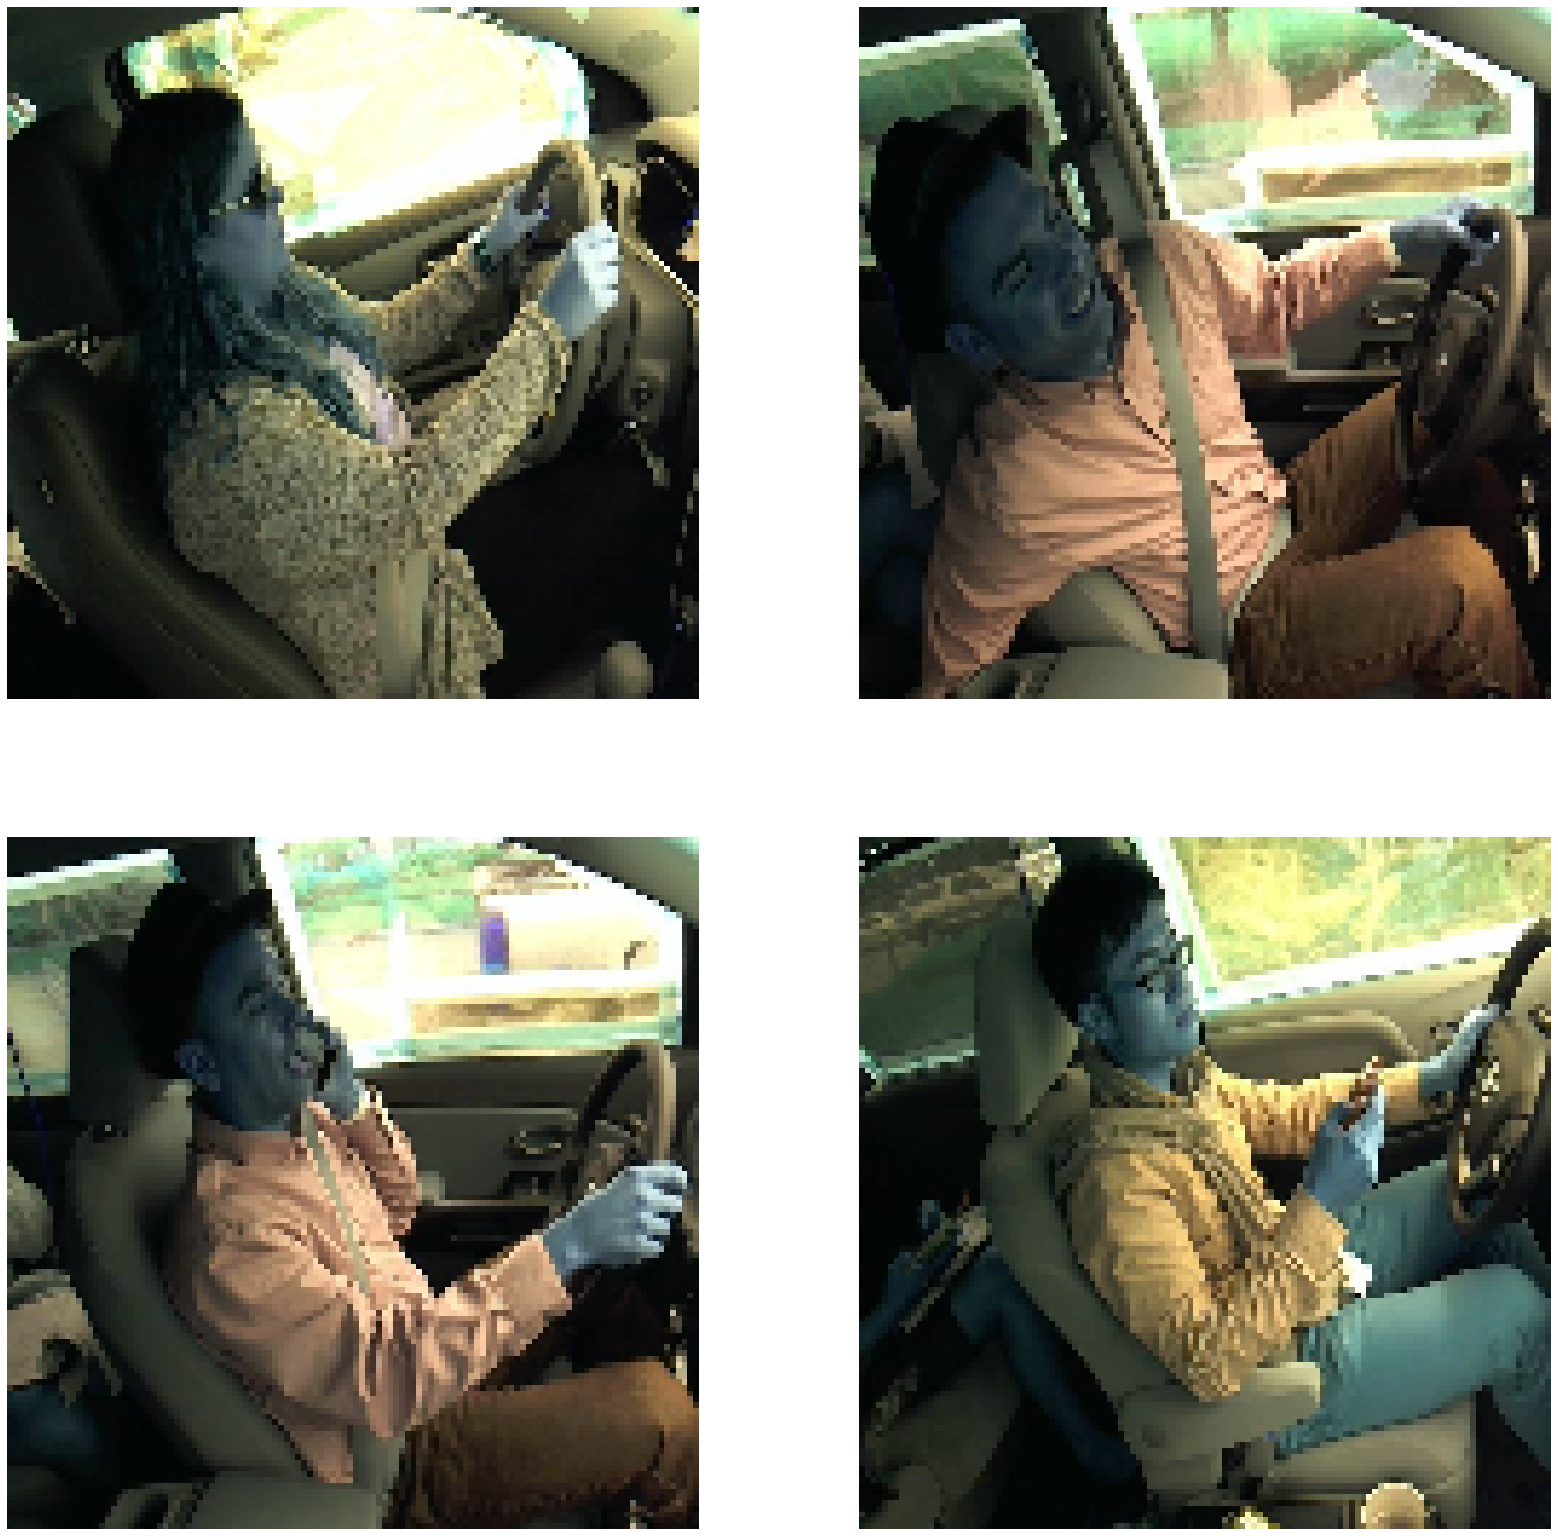

True: [0 7 4 1] Predicted [0 7 4 1]


In [ ]:

plot_image_matrix(x_test_imgs[0:4],[120,120,3],[28,28],True,)
print("True:", y_test_f[0:4], "Predicted", pred[0:4])

In [ ]:
# The 10 classes to predict are:

#     c0: safe driving
#     c1: texting - right
#     c2: talking on the phone - right
#     c3: texting - left
#     c4: talking on the phone - left
#     c5: operating the radio
#     c6: drinking
#     c7: reaching behind
#     c8: hair and makeup
#     c9: talking to passenger


(4, 120, 120, 3)
(4, 120, 120, 3) [120, 120, 3]


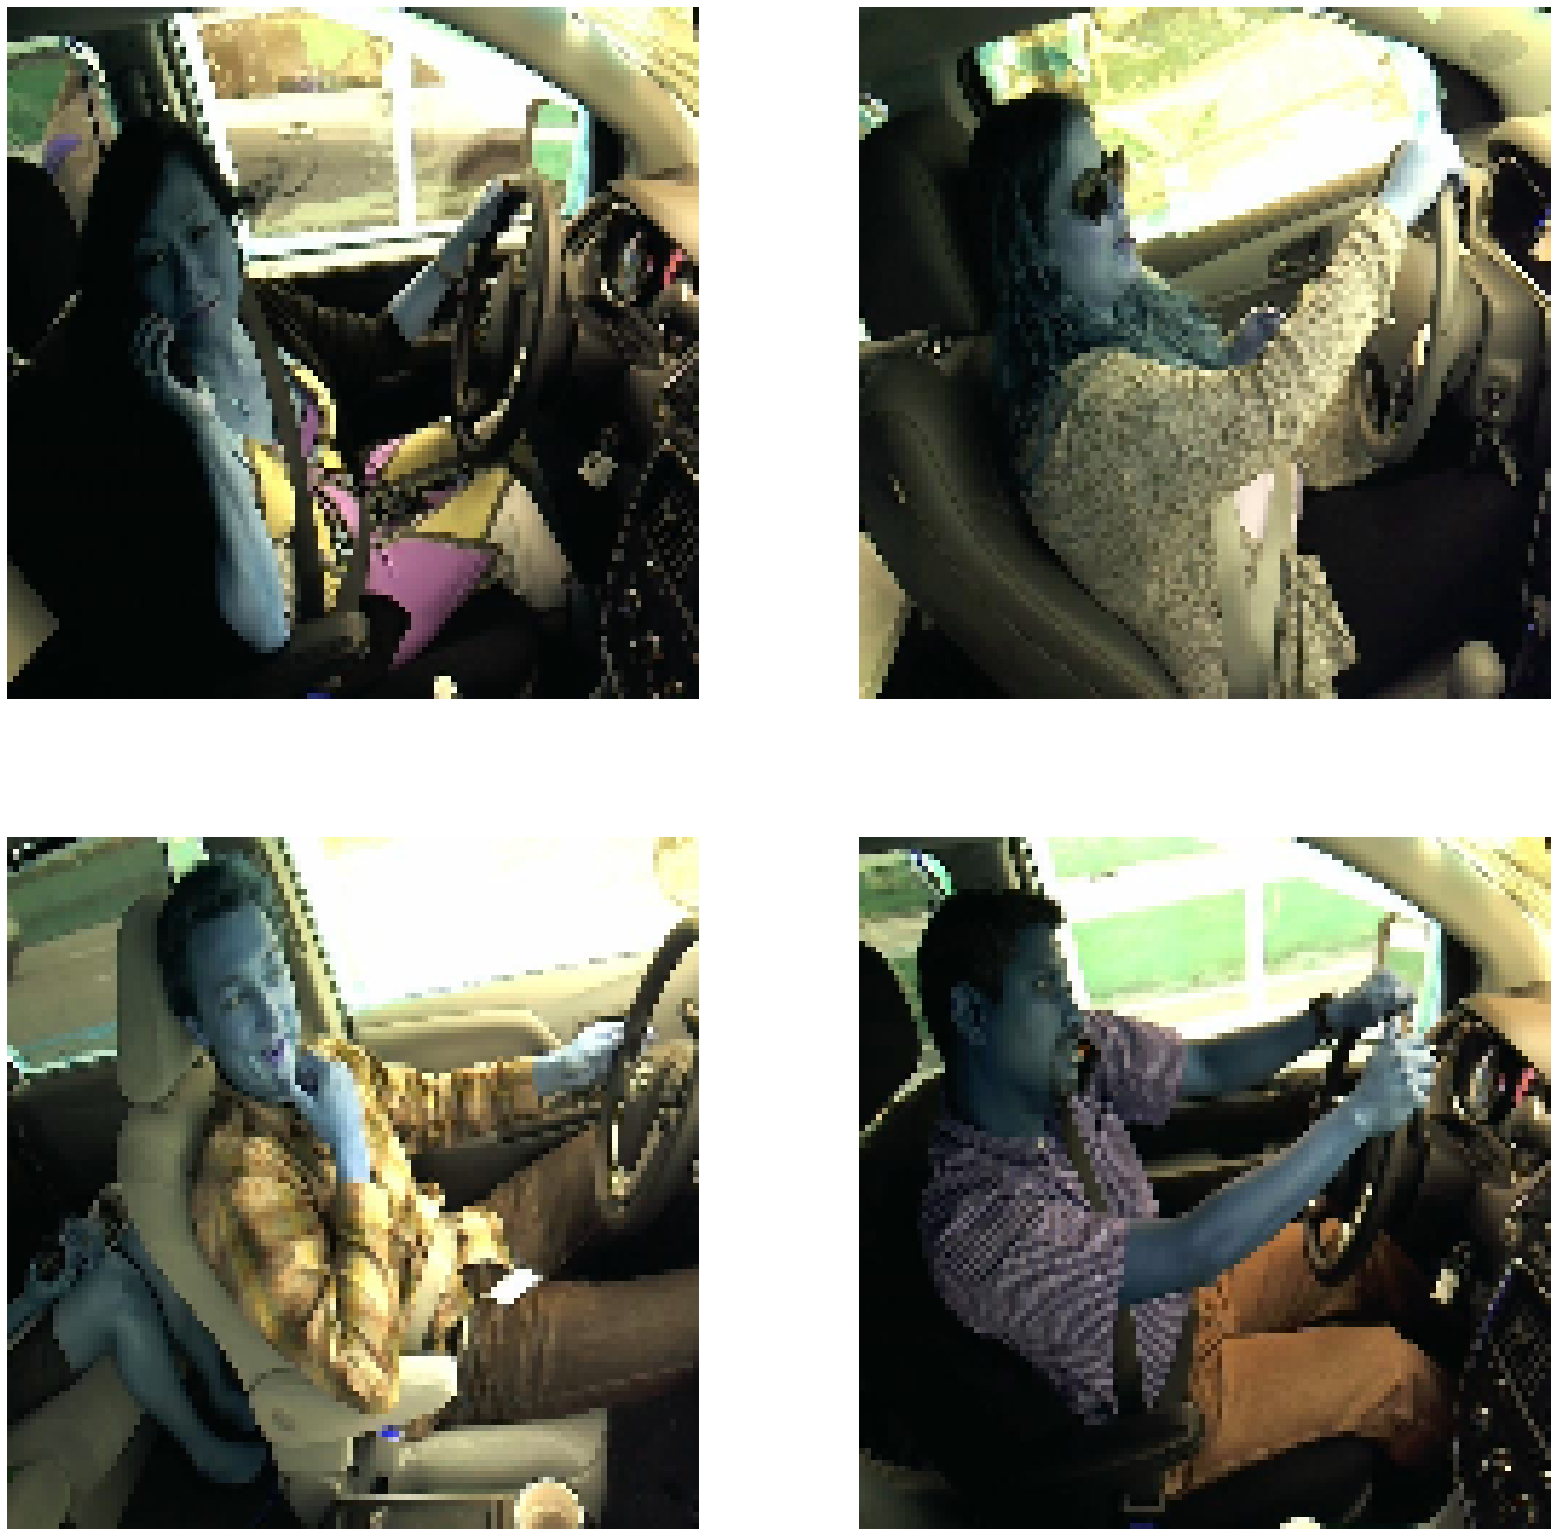

True: [2 3 9 4] Predicted [1 0 8 0]


In [ ]:
plot_image_matrix(x_test_imgs[mispreds[0:4]],[120,120,3],[28,28],True,)
print("True:", y_test_f[mispreds[0:4]], "Predicted", pred[mispreds[0:4]])

In [ ]:

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

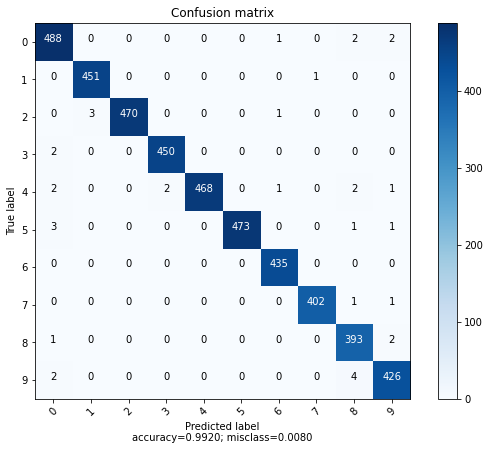

In [ ]:
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9",], normalize=False)